# Multinomial Regression Exercises

In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

## Exercise 1 [Easy] 


**1. *Save to disk the trace of the PyMC model from the lesson. Load it in this notebook.***

In [3]:
idata_multinomial = az.from_netcdf("idata_multinomial_pymc.nc")

**2. *Check that there are 11 parties, and that the posterior mean of `baseline` across all dimensions is 0.***

In [4]:
len(idata_multinomial.posterior["party"]) == 11

True

In [5]:
np.isclose(idata_multinomial.posterior["baseline"].mean(), 0)

True

## Exercise 2 [Easy]

Let's examine the correlation of `education` with voting preferences.

**1. *Make a forest plot for the PyMC model's education effect.***

Small tip: for the coming plots, transpose the xarray objects, so that Arviz displays the party first and you can clearly compare the demographics of the other variable.

### Forest plot of education effect

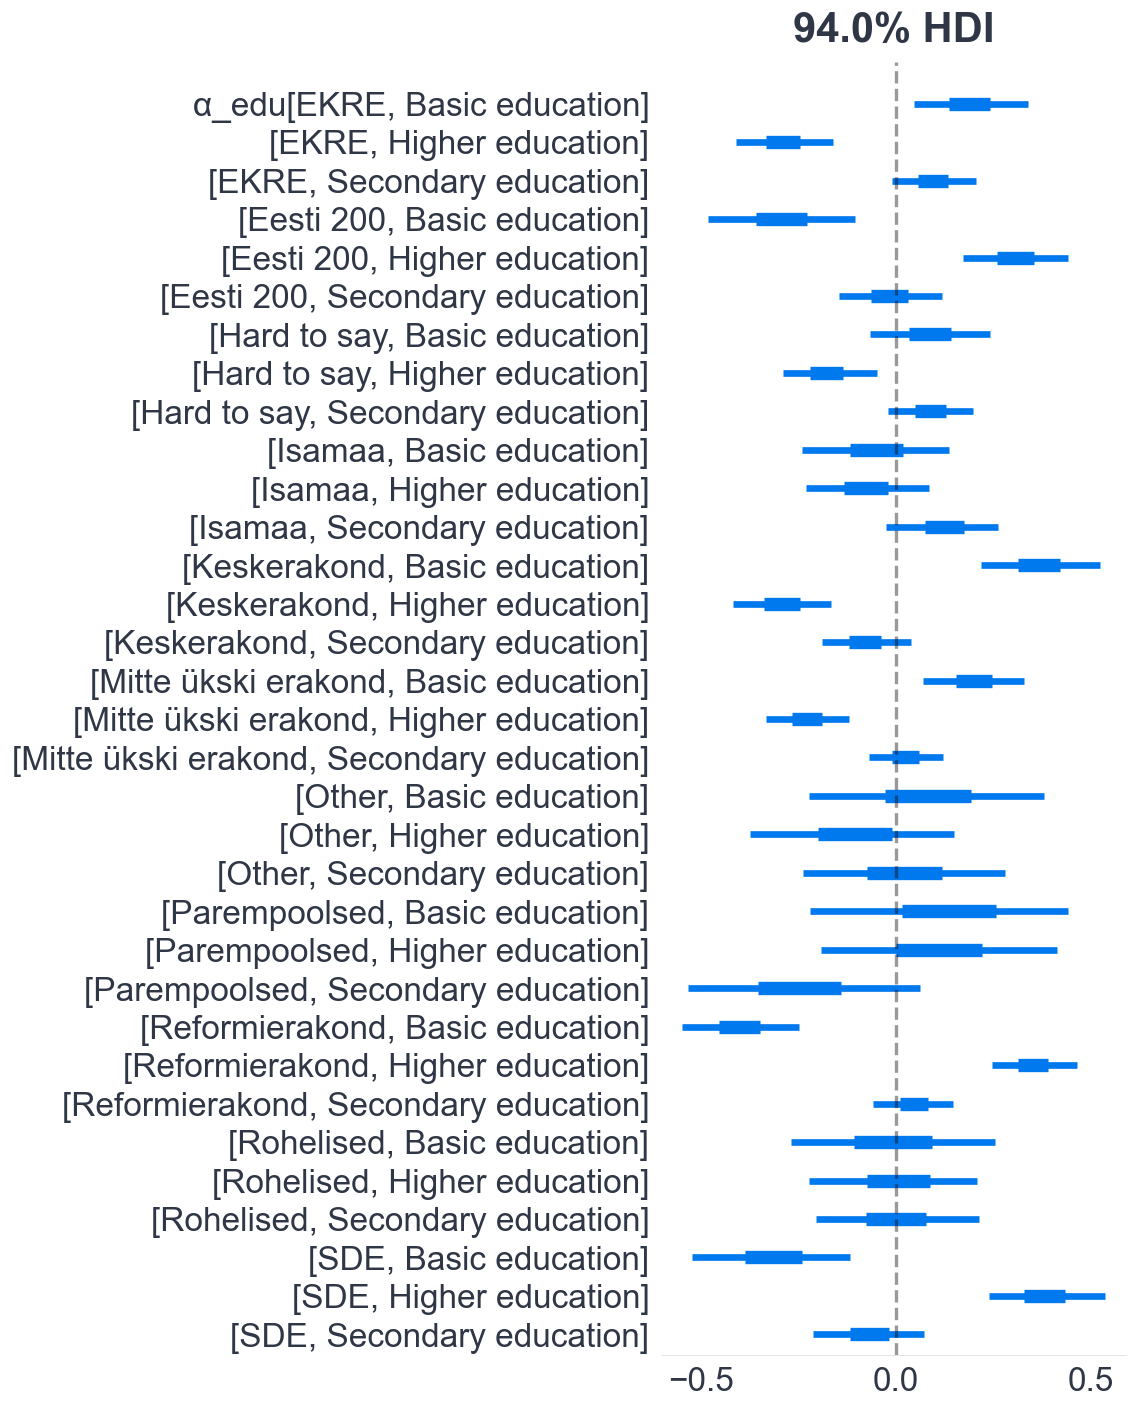

In [6]:
ax = az.plot_forest(
    idata_multinomial.posterior["α_edu"].T,
    combined=True,
    figsize=(5, 14),
)
ax[0].axvline(color="k", ls="--", alpha=0.4, lw=2);

**2. *Interpret this plot. In particular: How is education correlated with party preference? Can you see differences in the voting patterns of the different education levels?***

The effect of education seems quite big. For instance, **people with basic education** have a strong preference for EKRE, Keskerakond and Mitte. In contrast, they really dislike SDE, Reformierakond and Eesti.

The cool thing of the ZeroSumNormal and Multinomial is that these effects should be compensated by the other demographics. Interestingly, **people with secondary education** don't seem to have strong preferences (the reasons why would be interesting to talk about with a domain expert), so the zero-sum game should be visible on the higher education level.

And sure enough, the **most educated part of the population** really _dislikes_ EKRE, Keskerakond and Mitte... and prefers SDE, Reformierakond and Eesti -- the exact opposite of the lowest educated level!

Now let's look at the other estimates.

## Exercise 3 [Medium]

Now let's look at the association of `age` and vote.

**1. *Compute the posterior medians of `α_gender` and draw them as a heatmap, with gender horizontally and parties vertically.***

Hint: use `seaborn` to draw the heatmap.

### Heatmap of median gender effect

In [14]:
median_gender_df = (
    idata_multinomial.posterior["α_gender"]
    .median(("chain", "draw"))
    .to_dataframe()
    .unstack()
    .droplevel(0, axis="columns")
    .T
)
median_gender_df

gender,Female,Male
party,,
EKRE,-0.207045,0.207045
Eesti 200,-0.015463,0.015463
Hard to say,0.222215,-0.222215
Isamaa,-0.190769,0.190769
Keskerakond,0.080665,-0.080665
Mitte ükski erakond,0.015038,-0.015038
Other,-0.077581,0.077581
Parempoolsed,0.009078,-0.009078
Reformierakond,-0.010243,0.010243


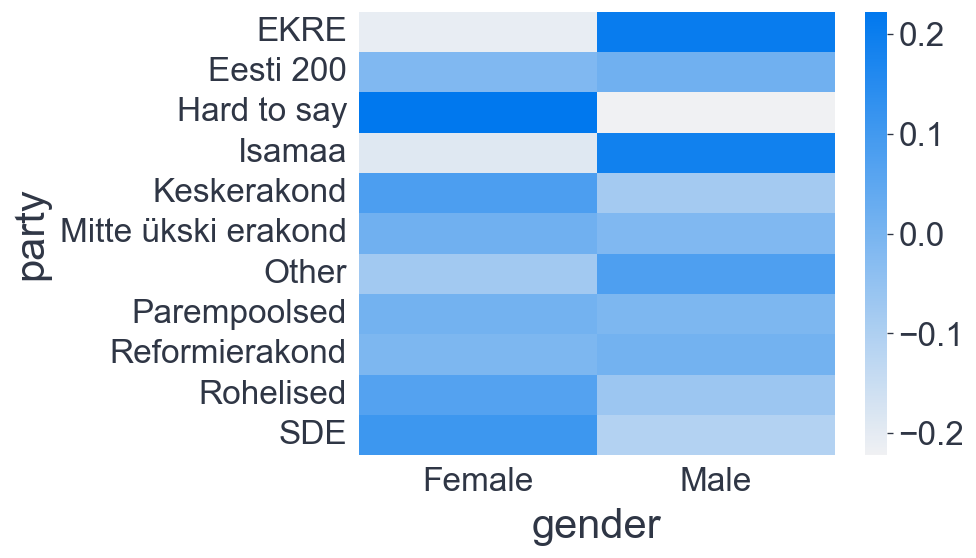

In [15]:
sns.heatmap(median_gender_df, cmap=sns.light_palette("#0078ee", as_cmap=True));

**2. *What are the median differences between men and women?***

The bluer, the more probable to vote for the given party. So, on average, women tend to favor SDE and Hard to say, while men strongly favor EKRE and Isamaa. 

These are just the median estimates, to help us get an idea of what to expect. Now, let's visualize the full distributions.

**3. *Do a ridge plot of `α_gender`.***

### Ridge plot of gender effect

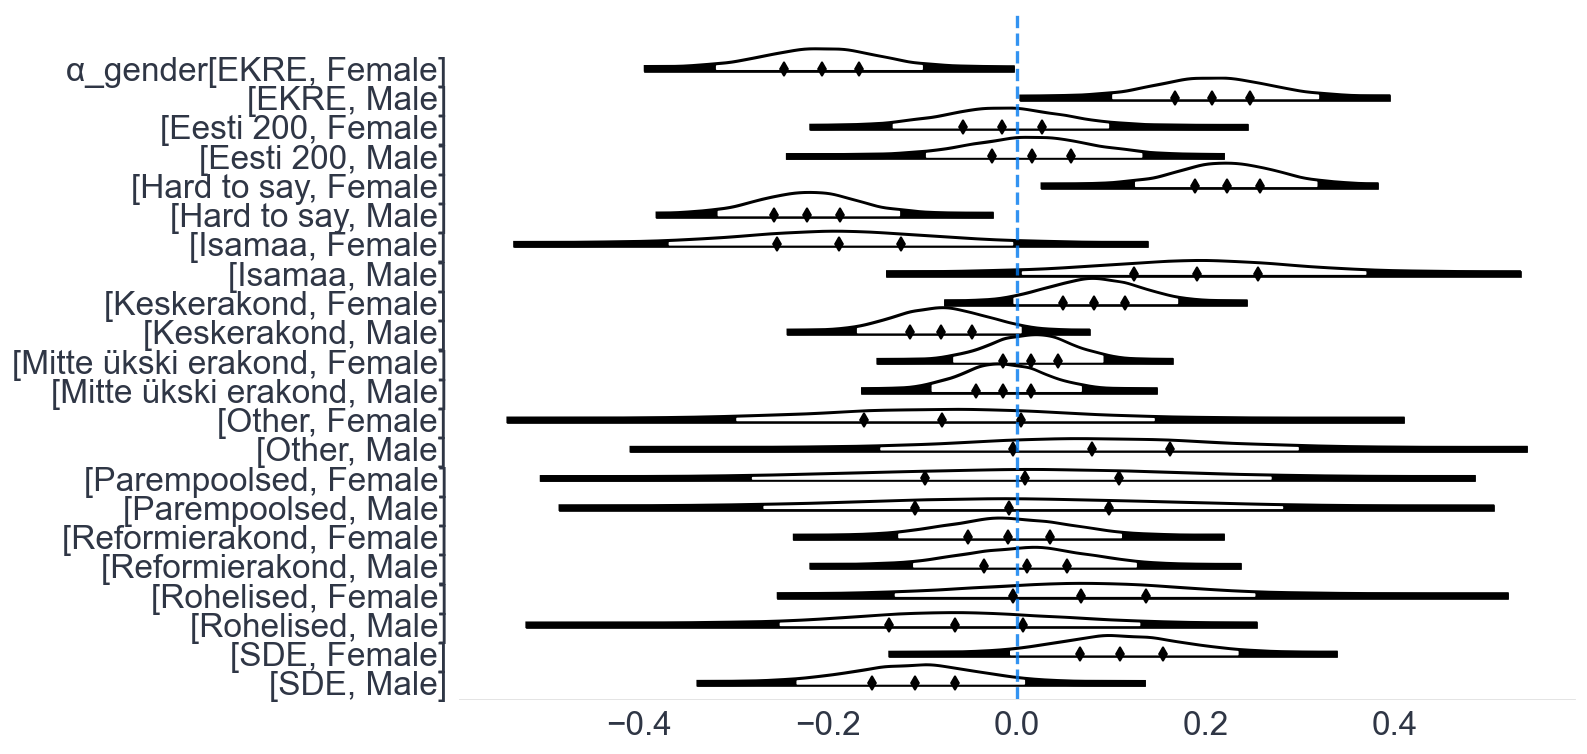

In [16]:
ax = az.plot_forest(
    idata_multinomial.posterior["α_gender"].T,
    combined=True,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    colors="white",
)
ax[0].axvline(ls="--", alpha=0.8, lw=2);

**4. *Do you spot any difference or new information compared to the medians?***

This confirms and refines our analysis of medians, and we can also notice that some parties have a big posterior uncertainty (mainly because they are small parties, for which we have just a handful of observations).

**5. *Do we need something else to compute the total gender effect? Or is `α_gender` all we need?***

Keep in mind this is _not_ the total gender effect. To get it, we need to **add the nationality effect, as well as the interaction of gender and nationality**. What we just looked at is the gender effect _for the average nationality_, which is not interpretable, since nationality is a discrete category.

All that to say: let's look at the nationality effect now.

**6. *Compute the posterior medians of `α_nat` and draw them as a heatmap, with nationality horizontally and parties vertically.***

### Heatmap of median nationality effect

In [17]:
median_nat_df = (
    idata_multinomial.posterior["α_nat"]
    .median(("chain", "draw"))
    .to_dataframe()
    .unstack()
    .droplevel(0, axis="columns")
    .T
)
median_nat_df

nationality,Estonian,Other
party,,
EKRE,0.133146,-0.133146
Eesti 200,0.070794,-0.070794
Hard to say,-0.202650,0.202650
Isamaa,0.653149,-0.653149
Keskerakond,-0.656673,0.656673
Mitte ükski erakond,-0.343656,0.343656
Other,-0.260373,0.260373
Parempoolsed,-0.083366,0.083366
Reformierakond,0.733126,-0.733126


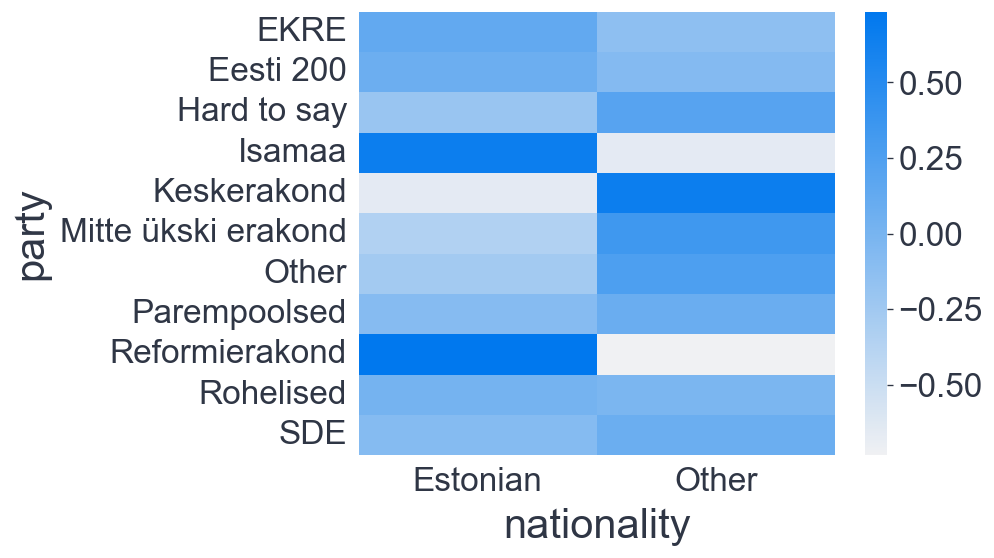

In [18]:
sns.heatmap(median_nat_df, cmap=sns.light_palette("#0078ee", as_cmap=True));

**7. *What are the median differences between Estonians and Other?***

The national preferences are quite clear: Isamaa and Reformierakond are mainly chosen by Estonians, while Russians favor Keskerakond. Let's see if the full distributions confirm this.

**8. *Do a ridge plot of `α_nat`.***

### Ridge plot of nationality effect

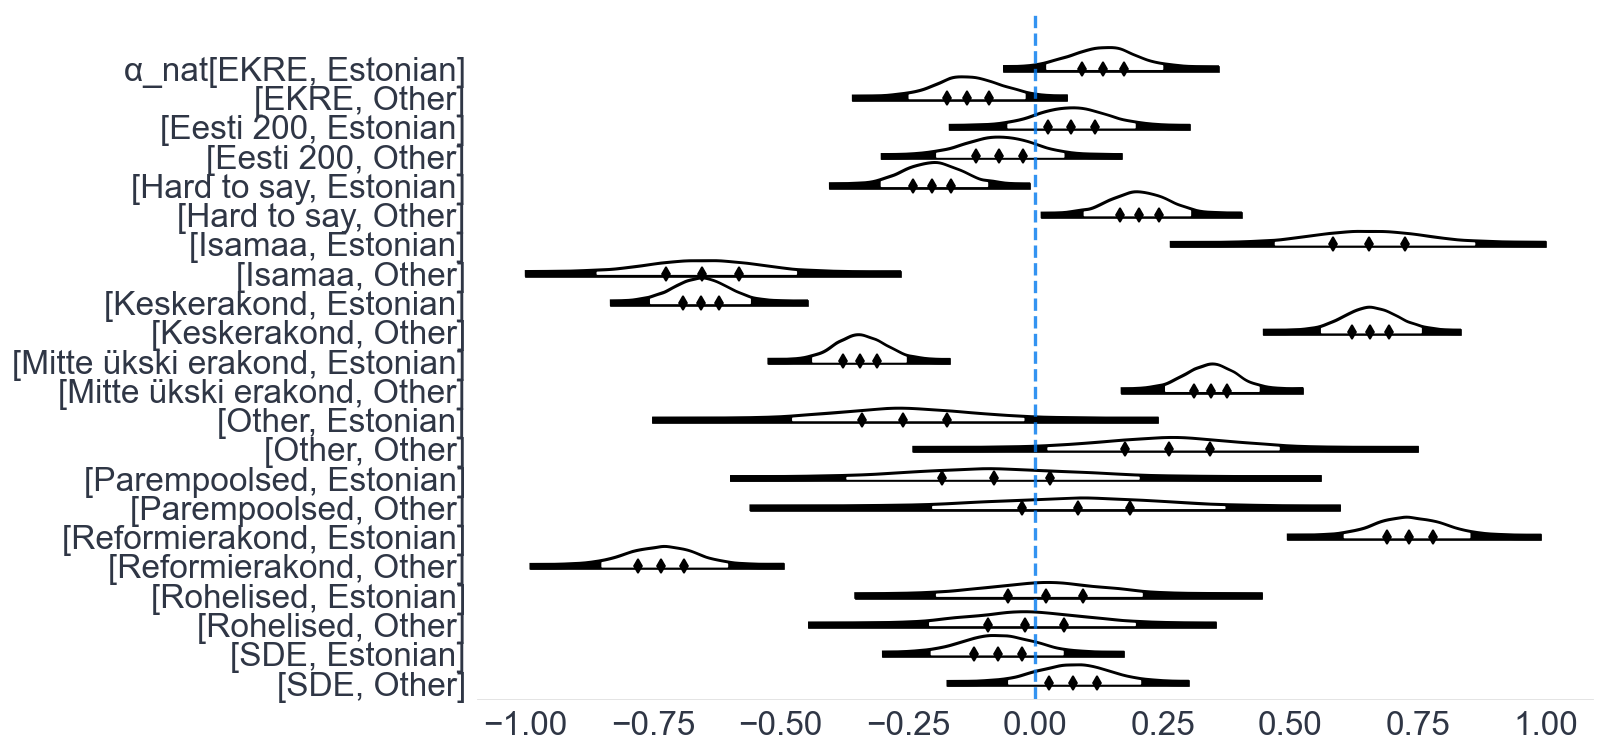

In [19]:
ax = az.plot_forest(
    idata_multinomial.posterior["α_nat"].T,
    combined=True,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    colors="white",
)
ax[0].axvline(ls="--", alpha=0.8, lw=2);

**9. *Do you spot any difference or new information compared to the medians?***

Interesting: the political landscape is actually more fragmented than we thought, and we would have missed that if we had only looked at median estimates. This is a general rule in the Bayesian framework: **only summarize your estimates when you absolutely have to**, and do it as late as possible in the workflow.

This is very different from the frequentist framework, where point estimates are the kings. But in the Bayesian framework, we try to throw away information as late as possible -- otherwise, why work so hard to get full posterior distributions in the first place?

Here, concretely, we of course see the **Estonian preference for Isamaa and Reformierakond**, and the **Russian preference for Keskerakond** -- because they are the most obvious ones, so the medians pick them up.

But there is a slight Estonian preference for EKRE and Esti (but too small for the median), and a slight Russian preference for Mitte, Other and SDE. Also note that Russians say they are more undecided than Estonians.

All in all, we get a really refined view of national preferences with this ridge plot, compared to only looking at median estimates.

However, **this is still not the total nationality effect**! Let's finally compute it.

**10. *Compute the posterior medians of the total nationality-gender effect and draw them as a heatmap, with gender-nationality horizontally and parties vertically.***

### Heatmap of median nationality-gender total effect

In [20]:
total_gender_nat = (
    idata_multinomial.posterior["α_gender"]
    + idata_multinomial.posterior["α_nat"]
    + idata_multinomial.posterior["α_gender_nat"]
).rename("estimate")

In [28]:
median_gender_nat_df = (
    total_gender_nat.median(("chain", "draw"))
    .to_dataframe()
    .unstack(level=[0, 2])
    .droplevel(0, axis="columns")
)

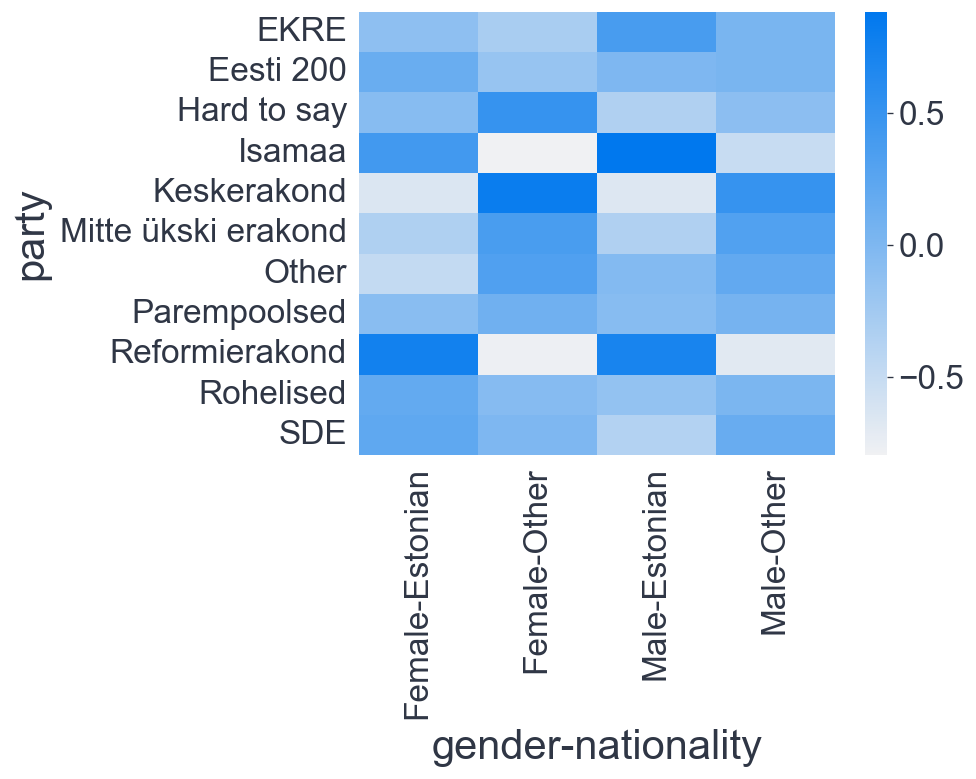

In [29]:
sns.heatmap(median_gender_nat_df, cmap=sns.light_palette("#0078ee", as_cmap=True));

**11. *What are the median differences between the combinations?***

Now we can see why the interaction is important: because, for instance, Estonian women do behave differently, both from Russian women _and_ Estonian men. So having this additional flexibility was helpful for our model.

We can already see different patterns, but this heatmap is of course harder to interpret. When looking at the full distributions, let's isolate some demographics, to ease interpretation.

For instance, let's look at Estonians.

**12. *Do a forest plot of the total gender effect for Estonians.***

### Forest plot of total gender effect for Estonians

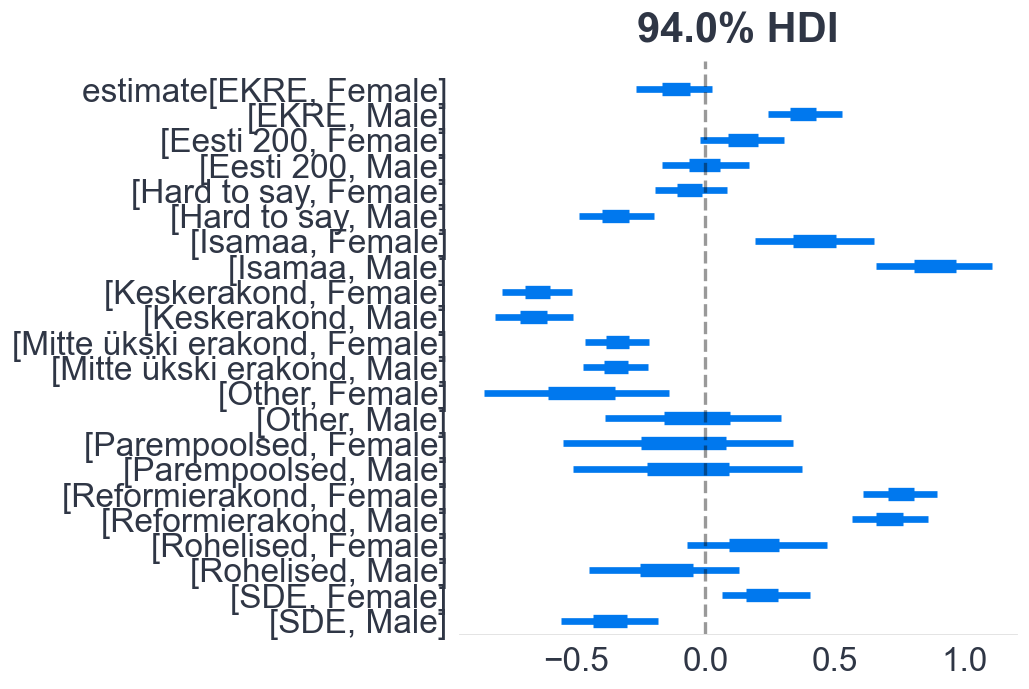

In [30]:
ax = az.plot_forest(
    total_gender_nat.T,
    coords=dict(nationality="Estonian"),
    combined=True,
)
ax[0].axvline(color="k", ls="--", alpha=0.4, lw=2);

**13. *How do Estonian men and women differ? Is this confirming or infirming posterior analyses we've done in the lesson?***

We can see that only four parties have the same popularity among Estonian men and women -- Keskerakond, Mitte, Parempoolsed and Reformierakond. Again, this shows that the interaction is helpful!

The biggest differences are for EKRE and Isamaa on one hand (favored by men), and Rohelised and SDE on the other (favored by women). These patterns confirm observations we've already made during the lesson.

Conversely, if we want to compare nationalities, we need to fix the gender. Let's say we're interested in the differences between Russian and Estonian men.

**14. *Do a forest plot of the total nationality effect for men.***

### Forest plot of total nationality effect for men

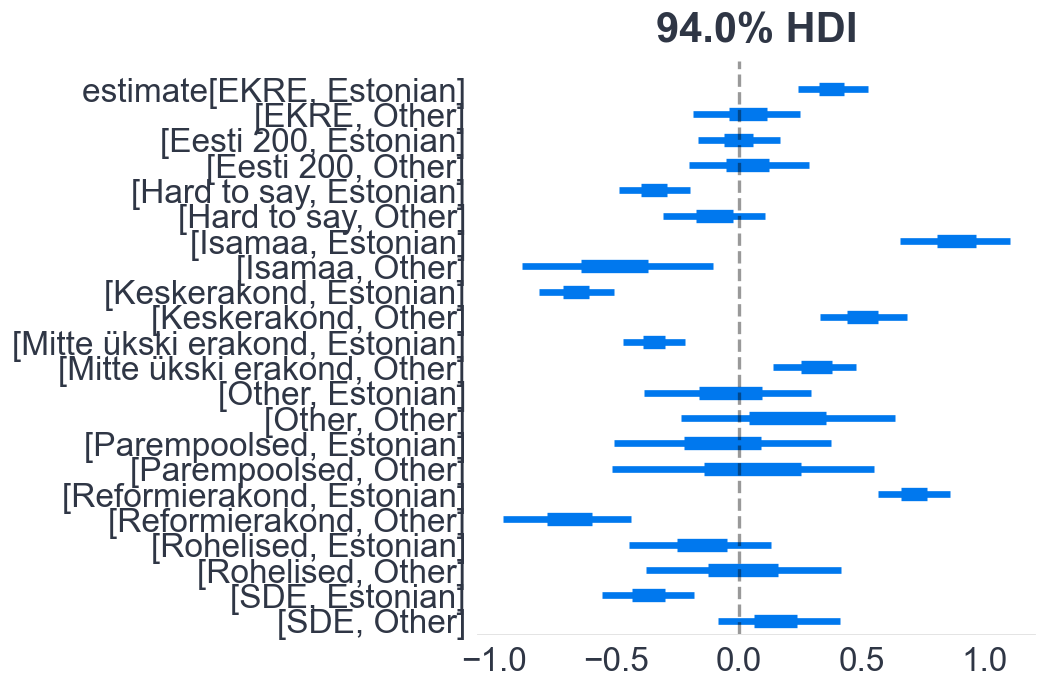

In [31]:
ax = az.plot_forest(
    total_gender_nat,
    coords=dict(gender="Male"),
    combined=True,
)
ax[0].axvline(color="k", ls="--", alpha=0.4, lw=2);

**15. *How do Russian and Estonian men differ?***

As expected, there are big differences: Estonian men have a strong preference for EKRE, Isamaa and Reformierakond, while Russians favor the parties that Estonian men dislike most -- Keskerakond, Mitte and SDE.

## Exercise 4 [Easy]

*Look at the demographics we didn't look at in the previous questions -- i.e the total gender effect for Russians, and the total nationality effect for women. Use the same workflow to anaylize them.*

*How surprised are you by all those parameters? Which questions would you ask to a domain expert, to poke at the model?*

*At this point, it should be clear to you how to do this, so we're not gonna give you the solution here. Rather, go* **post your analysis (and potential questions) [in the Discourse](https://community.intuitivebayes.com/) thread "AR Course -- Lesson 6, Exercise 4 Discussion"**, *and talk about it with the other students.*

## Exercise 5 [Hard] 

Remember the lesson? Of course you do, these were fun times! We promised you you'd look into exploring a given stratum of the population instead of the Estonian population as a whole. Well, this time has officially come!

But first, something you haven't seen yet and cannot guess. 

During the lesson, you may have wondered why we passed the index of the observations as the coordinates for the dimension `obs_idx`. Maybe you noticed that we could have set `demographics_order` as the index, and _then_ passed that index as coordinates. And you would be right, that would be an even better way!

The issue is that ArviZ doesn't handle `Multiindex` for now, so we have to add it _after_ backward and forward sampling. This requires some advanced use of xarray, so we're going to show you how to do it. Then, familiarize yourself with the code, and do it yourself at some point. Here we go!

First, we load our Estonian data, already aggregated:

In [32]:
observed_aggregated_answers = pd.read_csv("data/observed_aggregated_answers.csv")

In [33]:
demographics_order = [
    "age_group",
    "education",
    "gender",
    "nationality",
    "electoral_district",
    "unit",
]

In [34]:
# make ArviZ aware of the strata we're gonna select by:

obs_idx_detailed = observed_aggregated_answers.set_index(demographics_order).index
more_coords = {
    dem: ("obs_idx", observed_aggregated_answers[dem]) for dem in demographics_order
}
more_coords["obs_idx"] = obs_idx_detailed

And now let the magic happen. Here is the `posterior_predictive` group before:

In [35]:
idata_multinomial.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, obs_idx: 1157, party: 11)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * obs_idx  (obs_idx) int64 0 1 2 3 4 5 6 ... 1151 1152 1153 1154 1155 1156
  * party    (party) object 'EKRE' 'Eesti 200' ... 'Rohelised' 'SDE'
Data variables:
    answers  (chain, draw, obs_idx, party) int64 ...
Attributes:
    created_at:                 2023-04-27T20:01:40.439270
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

Now we add the new coords (to `constant_data` as well, because we need it for plotting):

In [36]:
idata_multinomial.posterior_predictive = (
    idata_multinomial.posterior_predictive.assign_coords(more_coords)
)
idata_multinomial.constant_data = idata_multinomial.constant_data.assign_coords(
    more_coords
)

And here is the `posterior_predictive` group after:

In [37]:
idata_multinomial.posterior_predictive

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 1000, obs_idx: 1157, party: 11)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * obs_idx             (obs_idx) object MultiIndex
  * party               (party) object 'EKRE' 'Eesti 200' ... 'Rohelised' 'SDE'
  * age_group           (obs_idx) object '16-24' '16-24' '16-24' ... '75+' '75+'
  * education           (obs_idx) object 'Basic education' ... 'Secondary edu...
  * gender              (obs_idx) object 'Female' 'Female' ... 'Male' 'Male'
  * nationality         (obs_idx) object 'Estonian' 'Estonian' ... 'Other'
  * electoral_district  (obs_idx) object 'Haabersti, Põhja-Tallinn ja Kristii...
  * unit                (obs_idx) object 'Haabersti' 'Kristiine' ... 'Pärnumaa'
Data variables:
    answers             (chain, draw, obs_idx, party) int64 ...
Attributes:
    created_at:                 2023-04-27T20:01:40.439270
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

Boom!

Now we can go ahead with our exercise.

***1. Compute the posterior retrodictive voting intentions of Estonians in the electoral district "Haabersti, Põhja-Tallinn ja Kristiine".***

In [38]:
demographics = dict(
    nationality="Estonian", electoral_district="Haabersti, Põhja-Tallinn ja Kristiine"
)

strata_retro_pred = (
    idata_multinomial.posterior_predictive["answers"].sel(**demographics).sum("obs_idx")
)

Did you spot the only novelty compared to the lesson code? That's right, just a few characters: `.sel(**demographics)`, and that's all!

Now, these are the raw "poll" numbers. We want to compute the posterior retrodictive _proportions_, which is what we're after. For this, we need the total number of respondents:

In [39]:
strata_N = idata_multinomial.constant_data["N"].sel(**demographics).sum("obs_idx")

And now we can compute the retrodictive voting intentions:

In [40]:
strata_retro_probs = (strata_retro_pred / strata_N) * 100

***2. Compute the observed proportions in this same strata (bonus points if you manage to only use the `InferenceData` object for this...).***

We're actually using the same workflow -- we just have to use a different `InferenceData` group!

In [41]:
observed_answers = (
    idata_multinomial.constant_data["obs"].sel(**demographics).sum("obs_idx")
)
observed_proportions = (observed_answers / strata_N) * 100

***3. Plot the posterior retrodictives with `az.plot_posterior`, and overlay the observations as reference values.***

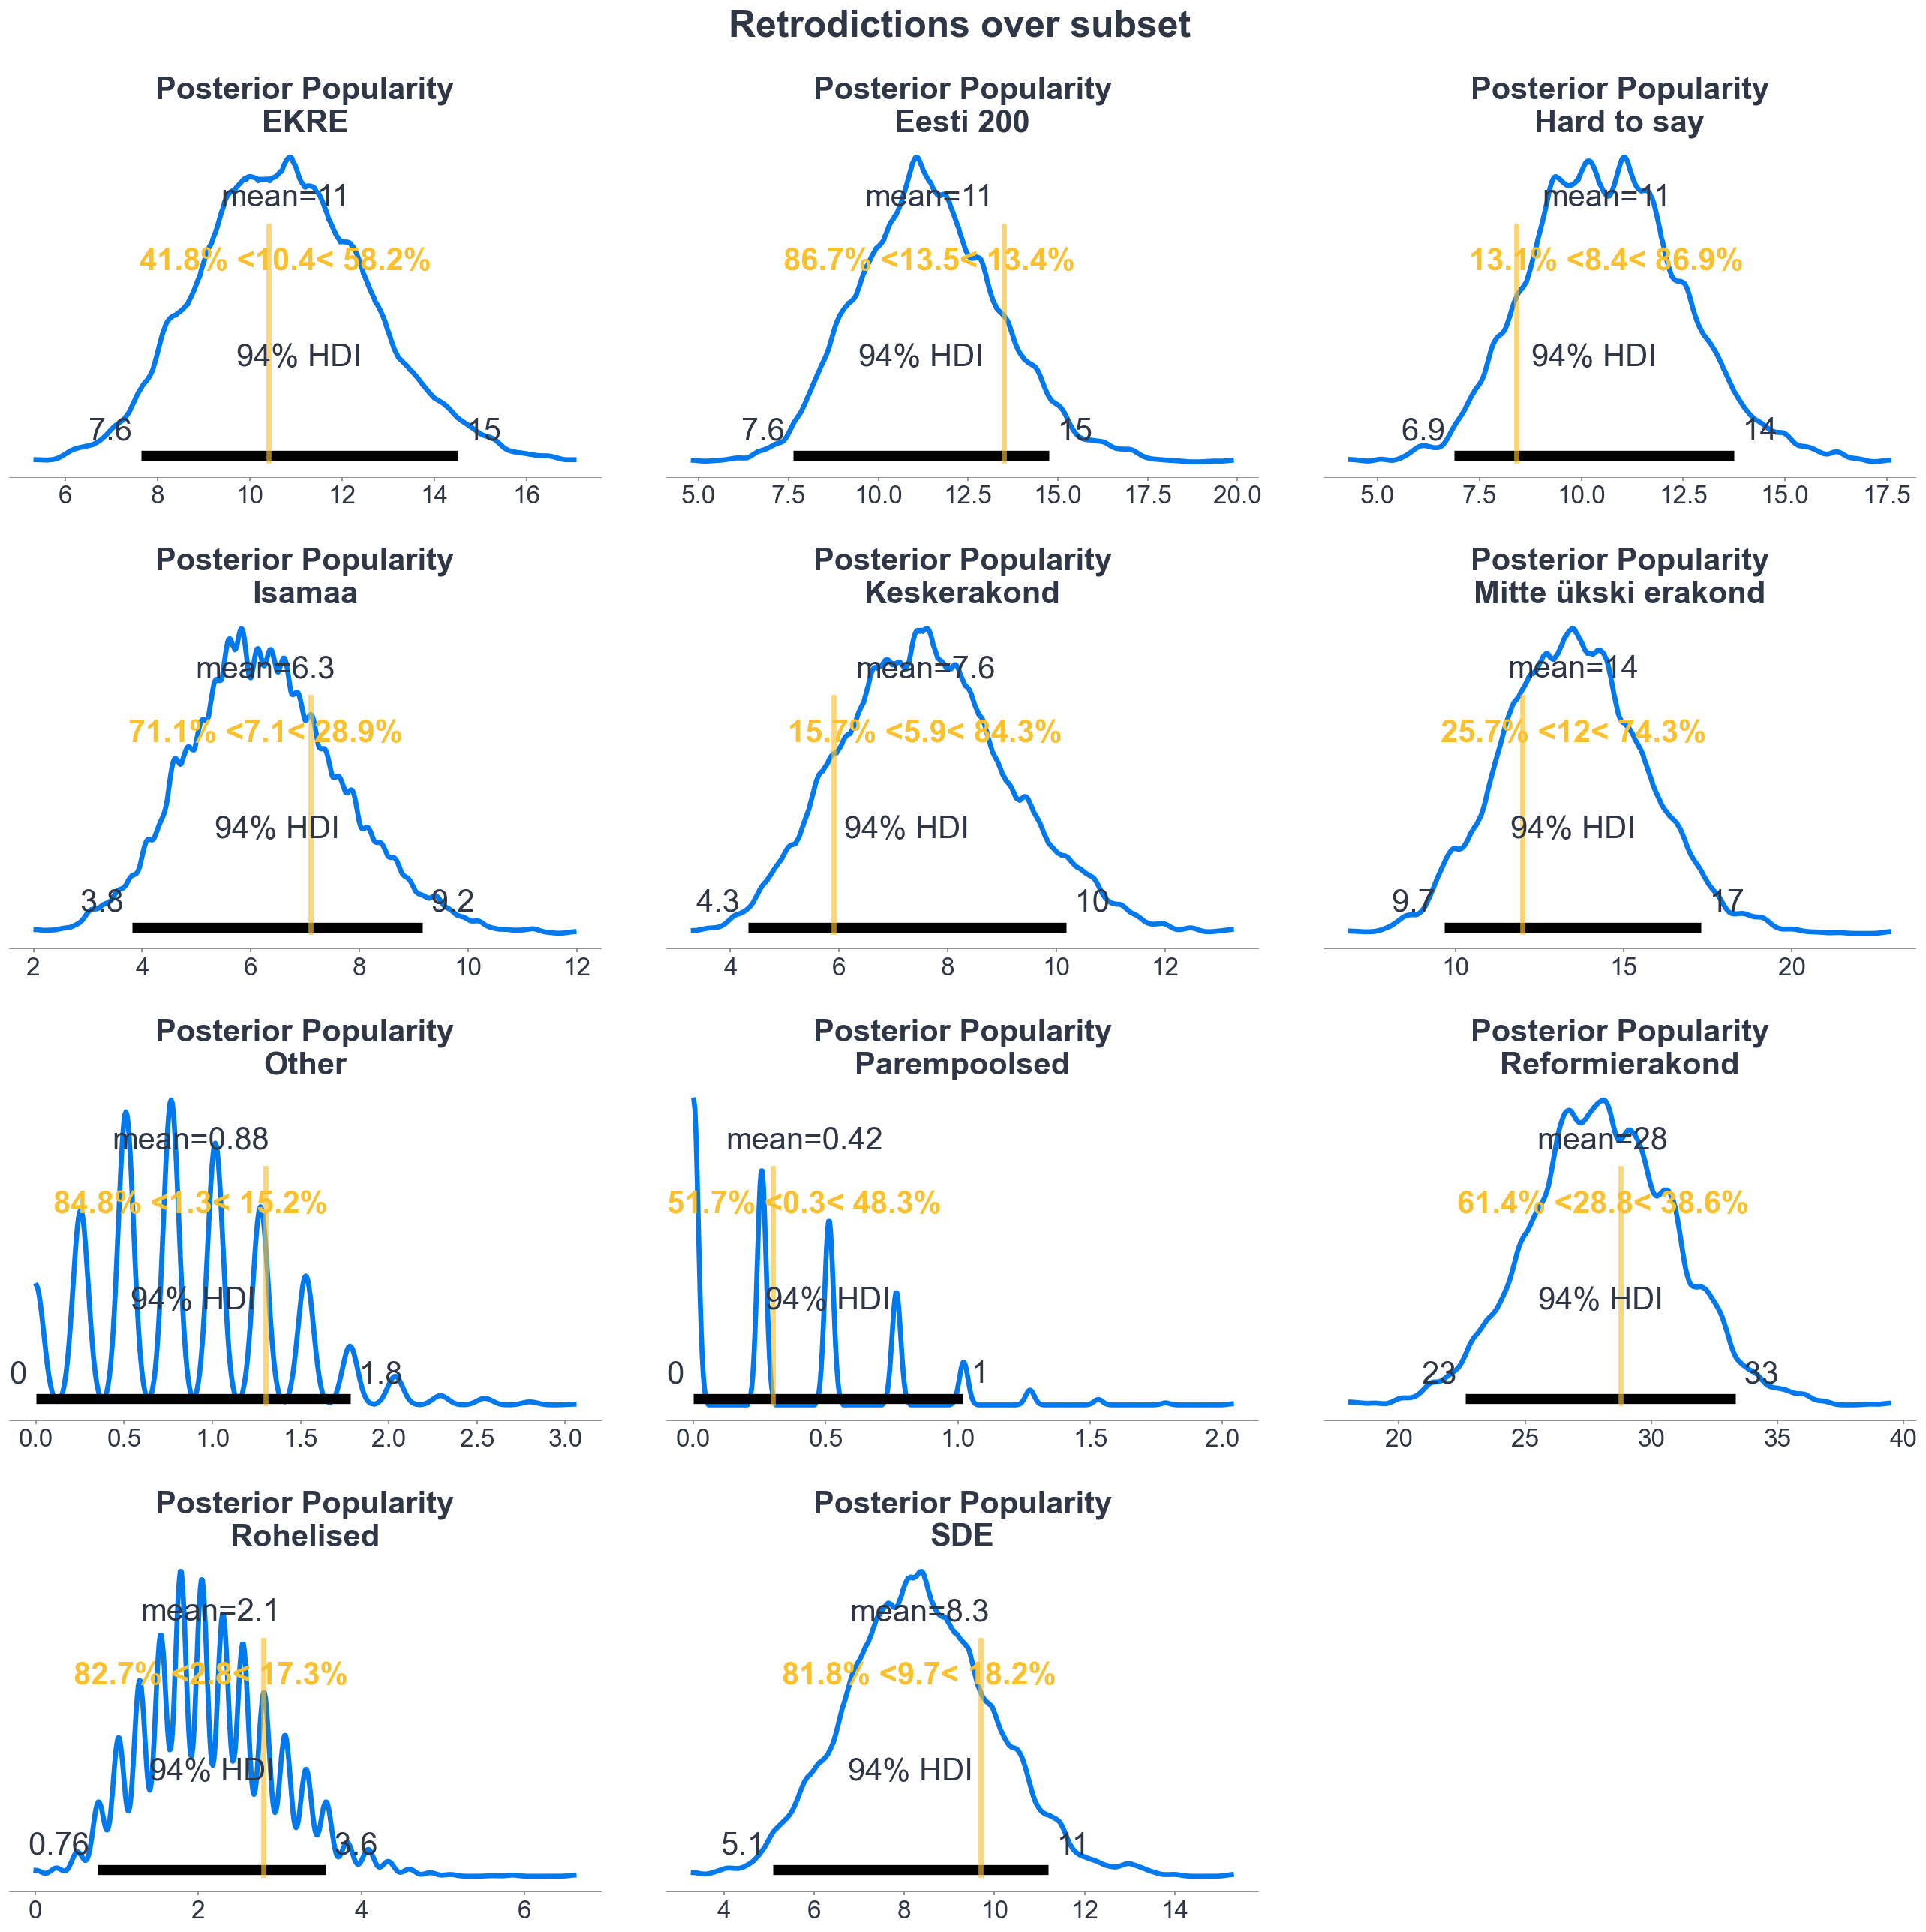

In [42]:
ax = az.plot_posterior(
    strata_retro_probs.rename("Posterior Popularity"),
    ref_val=observed_proportions.to_pandas().round(1).to_list(),
)
plt.suptitle("Retrodictions over subset", fontsize=30)
plt.tight_layout()

Once again, this looks really good! All the predictions look well calibrated, even though we don't have a lot of observations for some combinations of party and demographics. This is great sign for the model.

I encourage you to play around with this code: change the `demographics` dictionary and make new retrodictions for other combinations of the geo-demographics variables in this model. Feel free to post your beautiful original plots in the [Discourse](https://community.intuitivebayes.com/)!

By the way, do you know why we get these weird wiggles for some parties? Of course I'm not gonna tell you 😉 Rather, head over to the [Discourse](https://community.intuitivebayes.com/) and tell us what you think in the thread **"AR Course -- Lesson 6, Exercise 5 Discussion"**. See you there!